<a href="https://colab.research.google.com/github/karthik-25/music-generator/blob/main/music_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In [ ]:
!sudo apt install -y fluidsynth

In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!pip install pretty_midi

# Import Packages & Set Initial Config

In [6]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [80]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [81]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

# Download Data

In [82]:
data_dir = pathlib.Path('data/maestro-v2.0.0')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'maestro-v2.0.0-midi.zip',
      origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
      extract=True,
      cache_dir='.', cache_subdir='data',
  )

In [83]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print('Number of files:', len(filenames))

Number of files: 1282


# Inspect Midi File

In [84]:
sample_file = filenames[50]
pm = pretty_midi.PrettyMIDI(sample_file)

In [85]:
def display_audio(pm, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # create shorter version of generated waveform
  waveform_short = waveform[:seconds * _SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [86]:
display_audio(pm)

In [87]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Acoustic Grand Piano


In [88]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=66, note_name=F#4, duration=0.8776
1: pitch=67, note_name=G4, duration=0.3880
2: pitch=57, note_name=A3, duration=0.3542
3: pitch=62, note_name=D4, duration=1.1055
4: pitch=66, note_name=F#4, duration=0.6432
5: pitch=59, note_name=B3, duration=2.1055
6: pitch=55, note_name=G3, duration=0.5104
7: pitch=61, note_name=C#4, duration=0.3841
8: pitch=64, note_name=E4, duration=0.4284
9: pitch=62, note_name=D4, duration=0.4701


In [89]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [90]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     59  1.000000  3.105469  0.000000  2.105469
1     66  1.102865  1.980469  0.102865  0.877604
2     62  1.559896  2.665365  0.457031  1.105469
3     67  1.911458  2.299479  0.351562  0.388021
4     66  2.221354  2.864583  0.309896  0.643229

In [91]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['B3', 'F#4', 'D4', 'G4', 'F#4', 'A3', 'G3', 'B4', 'E4', 'C#4'],
      dtype='<U3')

In [92]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

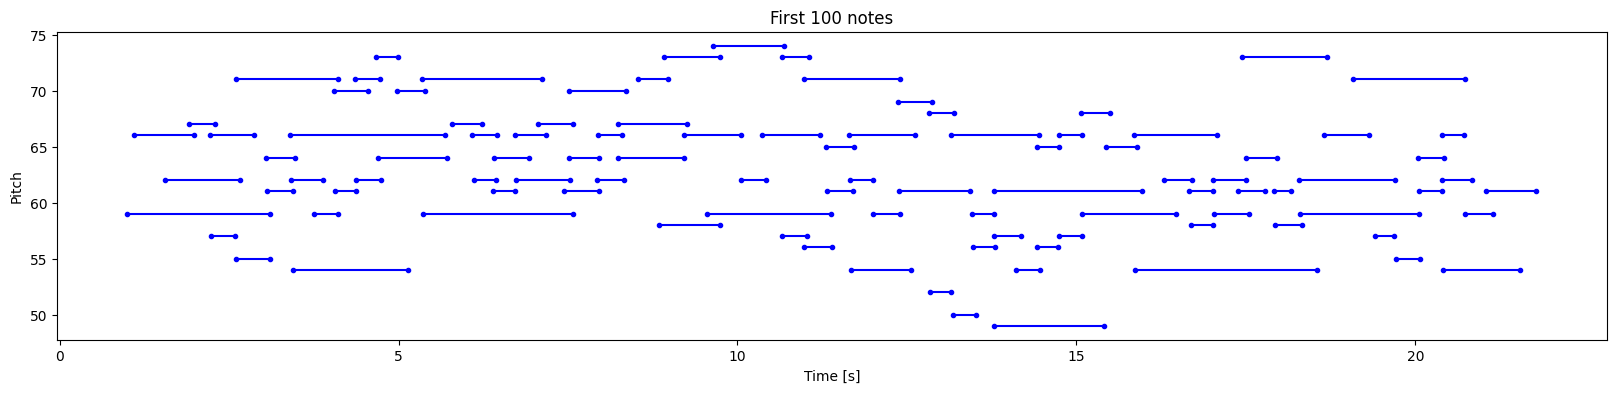

In [93]:
plot_piano_roll(raw_notes, count=100)

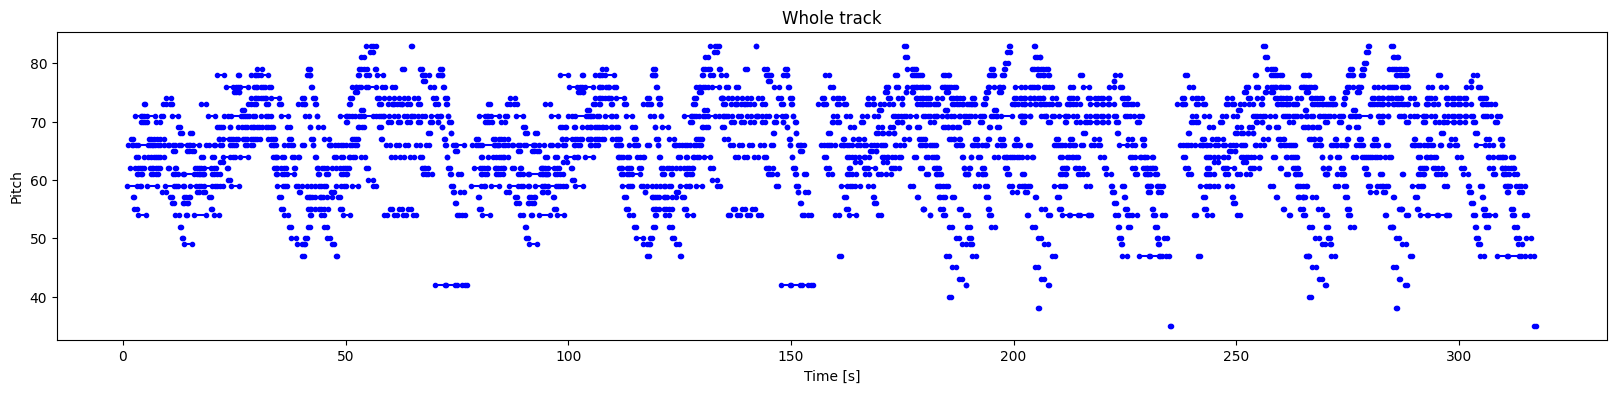

In [94]:
plot_piano_roll(raw_notes)

In [95]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

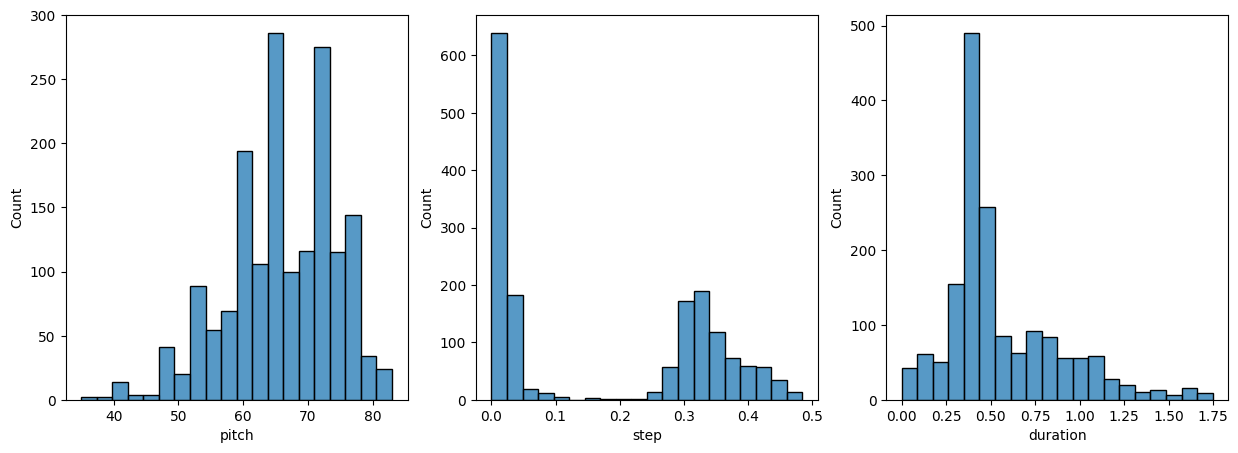

In [96]:
plot_distributions(raw_notes)

# Generate MIDI file

In [97]:
def notes_to_midi(notes: pd.DataFrame, out_file: str, instrument_name: str,
                  velocity: int = 100) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [98]:
example_file = 'example.midi'
example_pm = notes_to_midi(
    raw_notes, out_file=example_file, instrument_name=instrument_name)

In [99]:
display_audio(example_pm)

# Create Training Set

In [100]:
num_files = 15
all_notes = []
for f in filenames[:num_files]:
  notes = midi_to_notes(f)
  all_notes.append(notes)

all_notes = pd.concat(all_notes)

In [101]:
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)

Number of notes parsed: 124603


In [102]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)

In [103]:
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [104]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [106]:
seq_length = 100
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(100, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [107]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (100, 3)
sequence elements (first 10): tf.Tensor(
[[0.3515625  0.         0.04166667]
 [0.4453125  0.01041667 0.03515625]
 [0.484375   0.18880208 0.03645833]
 [0.390625   0.01041667 0.0390625 ]
 [0.4453125  0.1640625  0.03385417]
 [0.3515625  0.00911458 0.0546875 ]
 [0.484375   0.171875   0.04947917]
 [0.390625   0.015625   0.03385417]
 [0.515625   0.16145833 0.05859375]
 [0.421875   0.01822917 0.03125   ]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=85.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.12369791666666607>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.10416666666666607>}


In [108]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [109]:
train_ds.element_spec

(TensorSpec(shape=(64, 100, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

# Create and Train the Model

In [110]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [111]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
    'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
    'pitch': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    'step': mse_with_positive_pressure,
    'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 100, 3)]             0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 128)                  67584     ['input_2[0][0]']             
                                                                                                  
 duration (Dense)            (None, 1)                    129       ['lstm_1[0][0]']              
                                                                                                  
 pitch (Dense)               (None, 128)                  16512     ['lstm_1[0][0]']              
                                                                                            

In [112]:
losses = model.evaluate(train_ds, return_dict=True)
losses

1945/1945 [==============================] - 37s 5ms/step - loss: 5.5351 - duration_loss: 0.4962 - pitch_loss: 4.8464 - step_loss: 0.1925


{'loss': 5.535051345825195,
 'duration_loss': 0.4961848556995392,
 'pitch_loss': 4.846375942230225,
 'step_loss': 0.1924932897090912}

In [113]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [114]:
model.evaluate(train_ds, return_dict=True)

1945/1945 [==============================] - 9s 4ms/step - loss: 0.9310 - duration_loss: 0.4962 - pitch_loss: 4.8464 - step_loss: 0.1925


{'loss': 0.9309963583946228,
 'duration_loss': 0.4961848556995392,
 'pitch_loss': 4.846375942230225,
 'step_loss': 0.1924932897090912}

In [115]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [116]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
1945/1945 [==============================] - 17s 7ms/step - loss: 0.3568 - duration_loss: 0.1058 - pitch_loss: 4.0417 - step_loss: 0.0489
Epoch 2/50
1945/1945 [==============================] - 15s 8ms/step - loss: 0.3445 - duration_loss: 0.1018 - pitch_loss: 3.9072 - step_loss: 0.0473
Epoch 3/50
1945/1945 [==============================] - 15s 8ms/step - loss: 0.3399 - duration_loss: 0.0998 - pitch_loss: 3.8818 - step_loss: 0.0460
Epoch 4/50
1945/1945 [==============================] - 15s 8ms/step - loss: 0.3358 - duration_loss: 0.0979 - pitch_loss: 3.8498 - step_loss: 0.0453
Epoch 5/50
1945/1945 [==============================] - 15s 8ms/step - loss: 0.3324 - duration_loss: 0.0961 - pitch_loss: 3.8362 - step_loss: 0.0444
Epoch 6/50
1945/1945 [==============================] - 15s 7ms/step - loss: 0.3287 - duration_loss: 0.0946 - pitch_loss: 3.8141 - step_loss: 0.0434
Epoch 7/50
1945/1945 [==============================] - 15s 8ms/step - loss: 0.3253 - duration_loss: 0.092

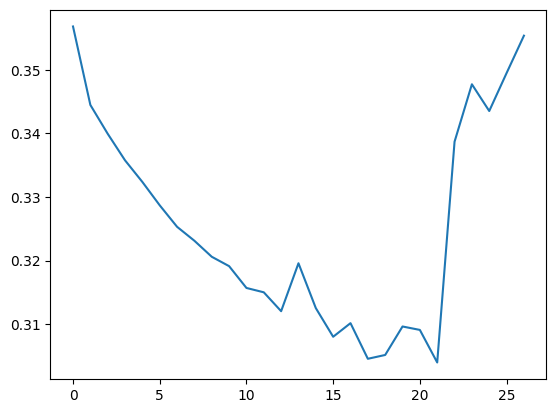

In [117]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

# Generate Notes

In [118]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [119]:
temperature = 2.0
num_predictions = 500

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for i in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  generated_notes.append((pitch, step, duration, start, end))
  pitch = pitch / vocab_size
  input_note = (pitch, step, duration)
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 [==============================] - 0s 45ms/step


In [120]:
generated_notes.head(10)

pitch      step  duration     start       end
0     47  0.195014  0.629173  0.195014  0.824187
1     72  0.194803  0.627027  0.389817  1.016844
2     58  0.149603  0.484891  0.539420  1.024311
3     47  0.190646  0.473556  0.730066  1.203622
4     60  0.271509  0.563789  1.001575  1.565363
5     76  0.253503  0.623167  1.255078  1.878245
6     50  0.179605  0.566787  1.434683  2.001470
7     74  0.155391  0.534054  1.590074  2.124128
8     84  0.166999  0.454507  1.757073  2.211581
9     52  0.196600  0.457007  1.953673  2.410680

In [121]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

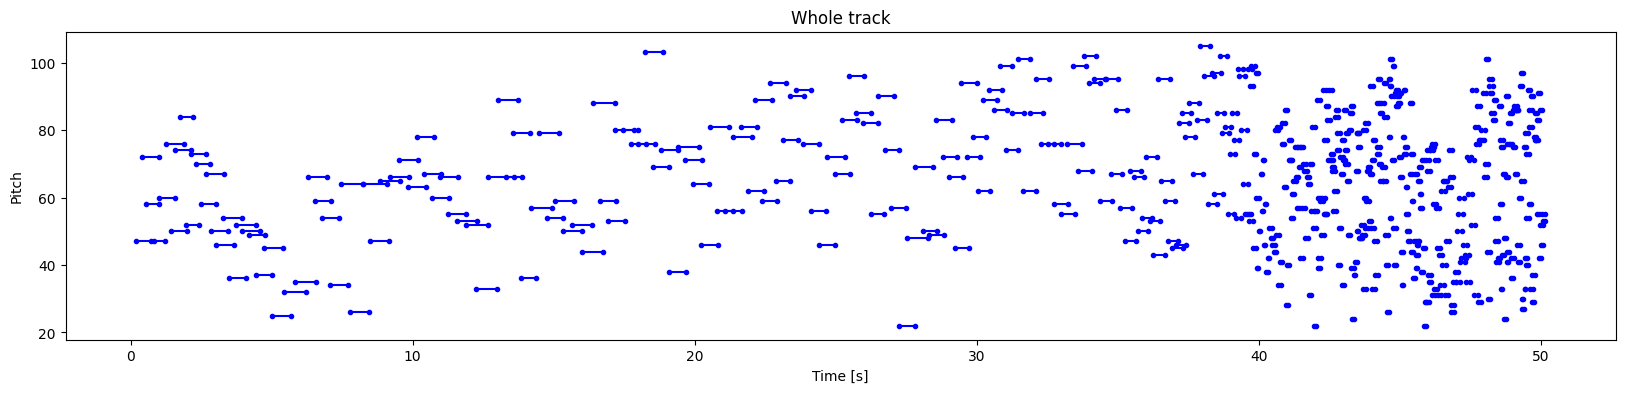

In [122]:
plot_piano_roll(generated_notes)

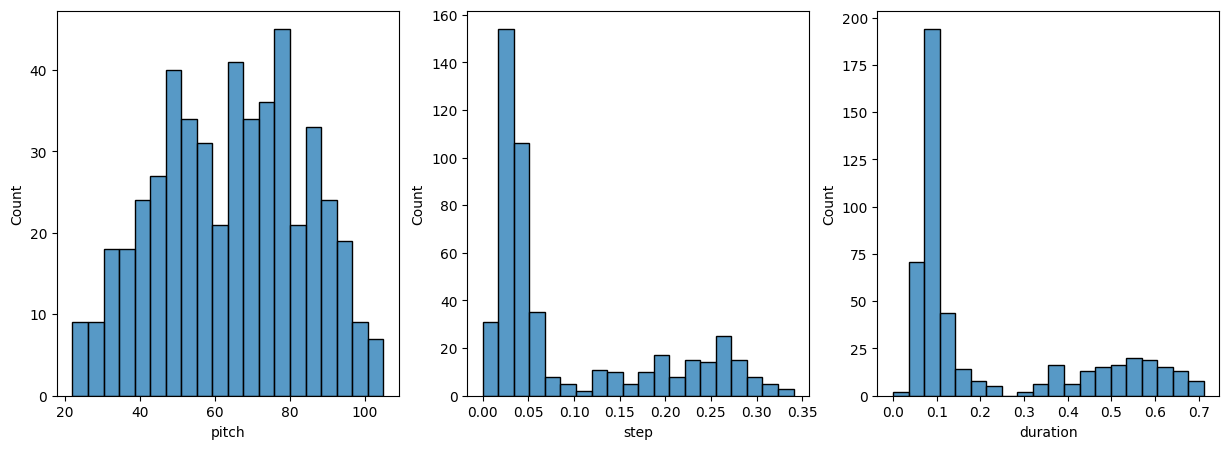

In [123]:
plot_distributions(generated_notes)